# Model creation for sentiment recognition

The following notebook creates a model to recognize sentiments. The data was extracted from the subreddits about **Bitcoin** and **Ethereum**.

In [125]:
import pandas as pd
import datetime
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
from tqdm import tqdm

tqdm.pandas()

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


# from google.colab import drive

# # Mount google drive
# drive.mount('/content/drive')

## 1. Load data

This data corresponds to Reddit posts made in cryptocurrency subreddits, the
data is about *Bitcoin* and *Ethereum* in particular.

In [164]:
files_path = "./reddit_comments/"


btc = pd.read_csv(files_path+'Bitcoin_combined_lemma.csv')
# eth = pd.read_csv(files_path+'ethereum_combined_lemma.csv')

# Format created_utc to a readable date format
btc['created_utc'] = btc['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
btc.rename(columns={"created_utc": "date"}, inplace=True)


In [165]:
btc.head()

,date,subreddit,body,origin
0,2020-12-31,Bitcoin,i understand what you re saying perhaps i shou...,comments
1,2020-12-31,Bitcoin,first time saved made money,submissions
2,2020-12-31,Bitcoin,deleted,comments
3,2020-12-31,Bitcoin,they have electrum on ios too edit they don t,comments
4,2020-12-31,Bitcoin,xhej,comments


## 2. Data cleaning

This will remove rows with very short posts or deleted posts

In [168]:
btc.dropna(subset=['body'], inplace=True)  # Remove rows where 'body' is NaN

# Use (?: ... ) for a non-capturing group
btc = btc[~btc['body'].str.contains(r'\b(?:deleted|removed)\b', case=False, na=False)]

btc = btc[btc['body'].str.len() > 5]  # Filter out comments shorter than 3 characters

btc.head()


,date,subreddit,body,origin
0,2020-12-31,Bitcoin,i understand what you re saying perhaps i shou...,comments
1,2020-12-31,Bitcoin,first time saved made money,submissions
3,2020-12-31,Bitcoin,they have electrum on ios too edit they don t,comments
6,2020-12-31,Bitcoin,look at this guy being invited to a new year s...,comments
8,2020-12-31,Bitcoin,you know what gives you an even bigger runway ...,comments


Also, to reduce the amount of data processed at the same time. The datasets will be separated in to their origin, having two datasets per cryptocurrency:

- Comments
- Submissions

In [169]:
btc_comments = btc[btc["origin"] == "comments"]
btc_submssions = btc[btc["origin"] == "submissions"]

btc_comments.head()

,date,subreddit,body,origin
0,2020-12-31,Bitcoin,i understand what you re saying perhaps i shou...,comments
3,2020-12-31,Bitcoin,they have electrum on ios too edit they don t,comments
6,2020-12-31,Bitcoin,look at this guy being invited to a new year s...,comments
8,2020-12-31,Bitcoin,you know what gives you an even bigger runway ...,comments
9,2020-12-31,Bitcoin,oh cool thanks,comments


Now, using a array of keywords commonly used by users related to the variation of price in crypto currencies a filter will be apply using regex.

In [170]:
keywords = ["price", "up", "down", "increase", "decrease", "rise", "fall", "bull", "bear", "market", "value", "worth"]
pattern = re.compile(r'\b(?:' + '|'.join(keywords) + r')\b', re.IGNORECASE)

# Filter comments that mention price-related topics
btc_filtered_comments = btc_comments[btc_comments['body'].apply(lambda x: bool(pattern.search(str(x))))]

btc_filtered_submissions = btc_submssions[btc_submssions['body'].apply(lambda x: bool(pattern.search(str(x))))]

btc_comments.head()

,date,subreddit,body,origin
0,2020-12-31,Bitcoin,i understand what you re saying perhaps i shou...,comments
3,2020-12-31,Bitcoin,they have electrum on ios too edit they don t,comments
6,2020-12-31,Bitcoin,look at this guy being invited to a new year s...,comments
8,2020-12-31,Bitcoin,you know what gives you an even bigger runway ...,comments
9,2020-12-31,Bitcoin,oh cool thanks,comments


## 4. Initialize sentiment analyzer

This analysis will be done using RoBERTa, it will label the emotions as:

- postive
- neutral
- negative

In [171]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the sentiment analysis function
def analyze_sentiment_roberta(text):
    # Tokenize and truncate text
    inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the correct device

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

    # Map labels to sentiment names
    if predicted_class_id == 2:
        return 1
    elif predicted_class_id == 1:
        return 0
    elif predicted_class_id == 0:
        return -1


In [172]:
btc_filtered_comments["sentiment"] = btc_filtered_comments["body"].progress_apply(analyze_sentiment_roberta)

100%|██████████| 596273/596273 [2:44:12<00:00, 60.52it/s]    
C:\Users\Diego\AppData\Local\Temp\ipykernel_18888\2516838107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_filtered_comments["sentiment"] = btc_filtered_comments["body"].progress_apply(analyze_sentiment_roberta)


In [183]:
btc_filtered_comments.head()

,date,subreddit,body,origin,sentiment
15,2020-12-31,Bitcoin,gee do you think the details matter at all do ...,comments,0
31,2020-12-31,Bitcoin,does he abstain the privilege of subordinating...,comments,0
36,2020-12-31,Bitcoin,possible but no one can time a market perfectl...,comments,0
46,2020-12-31,Bitcoin,thank you very much i ve appreciated the suppo...,comments,1
56,2020-12-31,Bitcoin,what car did you buy in that is still worth k ...,comments,1


# Model between prices and sentiment

Using the sentiments from the comments, now a relationship will be found between the price and the sentiment

In [174]:
files_path = "./crypto_prices/"

btc_prices = pd.read_csv(files_path+'Bitcoin_price.csv')
btc_prices = btc_prices.drop(columns=["Open", "High", "Low", "Vol.", "Change %"])
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'], format='%m/%d/%Y').dt.date

btc_prices.head()

,Date,Price
0,2022-11-30,"17,163.9"
1,2022-11-29,"16,440.4"
2,2022-11-28,"16,211.7"
3,2022-11-27,"16,425.6"
4,2022-11-26,"16,456.5"


In [202]:
sentiment_data = btc_filtered_comments

sentiment_data.to_csv()

KeyboardInterrupt: 

In [176]:
daily_sentiment = sentiment_data.groupby("date")["sentiment"].mean().reset_index()

daily_sentiment.head()

,date,sentiment
0,2020-12-31,-0.185315
1,2021-01-01,-0.097361
2,2021-01-02,-0.118750
3,2021-01-03,-0.110052
4,2021-01-04,-0.147521


In [184]:
common_dates = btc_prices['Date'].isin(daily_sentiment['date'])
price_data_filtered = btc_prices[common_dates]

price_data_filtered.rename(columns={"Date": "date"}, inplace=True)
price_data_filtered.head()

C:\Users\Diego\AppData\Local\Temp\ipykernel_18888\2444518292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data_filtered.rename(columns={"Date": "date"}, inplace=True)


,date,Price
1,2022-11-29,"16,440.4"
2,2022-11-28,"16,211.7"
3,2022-11-27,"16,425.6"
4,2022-11-26,"16,456.5"
5,2022-11-25,"16,512.3"


In [185]:
merged_data = pd.merge(daily_sentiment, price_data_filtered, on="date", how="inner")
merged_data['Price'] = merged_data['Price'].replace(',', '', regex=True).astype(float)

merged_data.head()

,date,sentiment,Price
0,2021-01-01,-0.097361,29359.9
1,2021-01-02,-0.118750,32193.3
2,2021-01-03,-0.110052,32958.9
3,2021-01-04,-0.147521,32022.6
4,2021-01-05,-0.146739,33991.5


In [197]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize 'Price' column
merged_data[['Standardized Price']] = scaler.fit_transform(
    merged_data[['Price']]
)

# Calculate the mean and standard deviation of 'sentiment'
sentiment_mean = merged_data['sentiment'].mean()
sentiment_std = merged_data['sentiment'].std()

# Standardize 'sentiment' column
merged_data['Standardized Sentiment'] = (merged_data['sentiment'] - sentiment_mean) / sentiment_std

# Calculate the current range of standardized sentiment
current_sentiment_range = merged_data['Standardized Sentiment'].max() - merged_data['Standardized Sentiment'].min()

# Calculate the desired range based on standardized price range
desired_range = merged_data['Standardized Price'].max() - merged_data['Standardized Price'].min()

# Calculate the scaling factor to match the sentiment range to price range
scaling_factor = desired_range / current_sentiment_range

# Adjust standardized sentiment to match the price range
merged_data['Adjusted Standardized Sentiment'] = merged_data['Standardized Sentiment'] * scaling_factor

# Display the min and max of the adjusted sentiment to verify the range
adjusted_min = merged_data['Adjusted Standardized Sentiment'].min()
adjusted_max = merged_data['Adjusted Standardized Sentiment'].max()

# Output the adjusted data and the new range
print("Adjusted Sentiment Range:", adjusted_min, adjusted_max)
merged_data.head()


Adjusted Sentiment Range: -2.1414367968010537 1.7180764136140438


,date,sentiment,Price,Standardized Price,Standardized Sentiment,Adjusted Standardized Sentiment
0,2021-01-01,-0.097361,29359.9,-0.700595,1.922367,1.048880
1,2021-01-02,-0.118750,32193.3,-0.489287,1.522372,0.830635
2,2021-01-03,-0.110052,32958.9,-0.432191,1.685027,0.919383
3,2021-01-04,-0.147521,32022.6,-0.502017,0.984316,0.537062
4,2021-01-05,-0.146739,33991.5,-0.355182,0.998941,0.545041


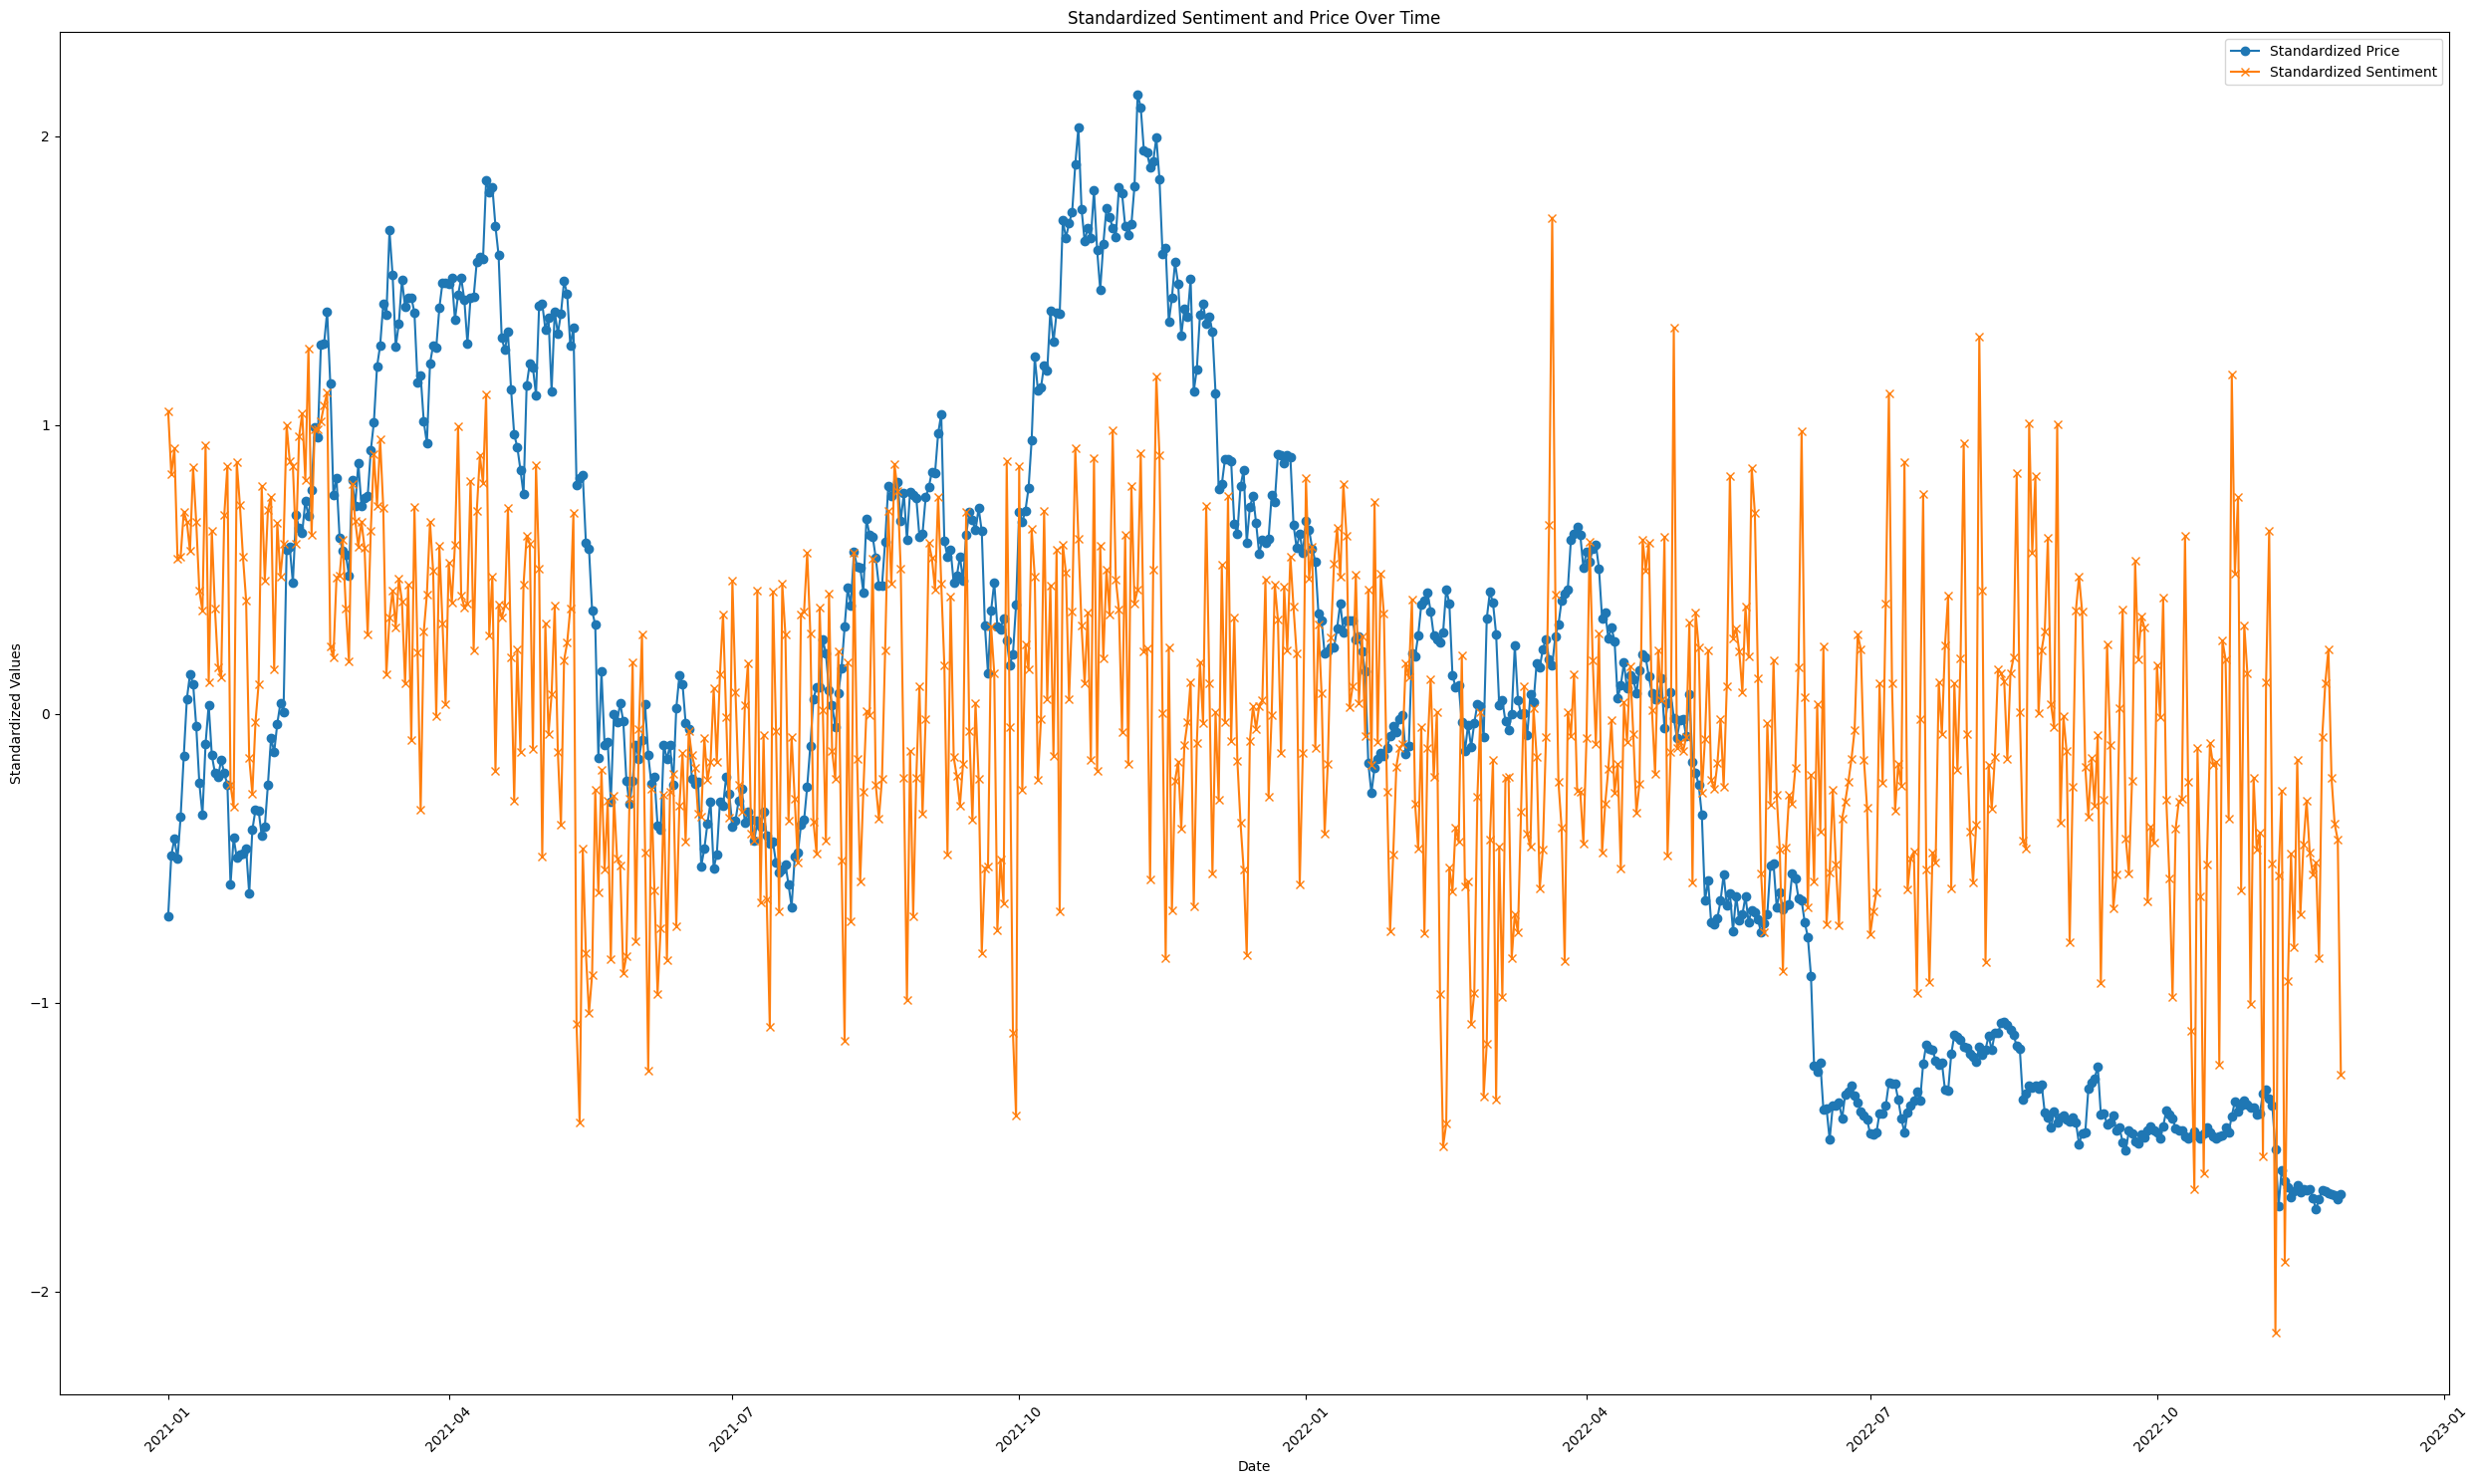

In [204]:
plt.figure(figsize=(25, 15))

# Plot standardized price
plt.plot(merged_data['date'], merged_data['Standardized Price'], label='Standardized Price', marker='o')

# Plot standardized sentiment
plt.plot(merged_data['date'], merged_data['Adjusted Standardized Sentiment'], label='Standardized Sentiment', marker='x')

# Adding title and labels
plt.title("Standardized Sentiment and Price Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Values")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [200]:
X = merged_data[['Adjusted Standardized Sentiment']]
y = merged_data['Standardized Price']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict and calculate R-squared
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
r2

0.09463392834697126